First, we import our dependencies:

In [2]:
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
import sqlite3 as sql
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

Now, we connect to the database:

In [3]:
conn = sql.connect('database.sqlite')
cur = conn.cursor()

This function will help us create Pandas DataFrames from SQL queries:

In [4]:
def get_dataframe_from_query(query, params=None):
    cur.execute(query, params or ())
    rows = cur.fetchall()
    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(rows, columns=colnames)

We create an interactive UI for viewing samples of the database and exporting its data:

In [5]:
def create_button(description, style=None, handler=None):
    btn = widgets.Button(description=description)
    if style:
        btn.button_style = style
    if handler:
        btn.on_click(handler)
    return btn

def display_with_navigation(elements, data=None):
    clear_output(wait=True)
    display(widgets.VBox(elements))
    if data is not None:
        display(data)

def on_exit_clicked():
    clear_output()

exit_button = lambda: create_button('Exit', 'danger', handler=lambda b: on_exit_clicked())

In [9]:
def export_data(df, format_type, filename):
    export_methods = {
        'CSV': lambda: df.to_csv(f'{filename}.csv', index=False),
        'Excel': lambda: df.to_excel(f'{filename}.xlsx', index=False),
        'JSON': lambda: df.to_json(f'{filename}.json', orient='records', indent=2)
    }
    
    export_methods[format_type]()
    print(f"{format_type} export completed: {filename}.{format_type.lower()}")

def show_main_menu():
    display_with_navigation([
        create_button('View sample', handler=lambda b: show_sample_submenu()),
        create_button('Export', handler=lambda b: show_export_submenu()),
        exit_button()
    ])

def show_category_submenu(selected_category=None):
    # Get categories and create buttons
    categories = [row[0] for row in get_dataframe_from_query("SELECT DISTINCT category FROM food_inventory ORDER BY category;").values]
    
    cat_buttons = [
        create_button(cat, handler=lambda b, category=cat: show_category_submenu(selected_category=category))
        for cat in categories
    ]
    
    return_btn = create_button('Return', 'danger', handler=lambda b: show_sample_submenu())
    buttons = cat_buttons + [return_btn]
    
    data = None
    if selected_category is not None:
        data = get_dataframe_from_query(
            "SELECT * FROM food_inventory WHERE category = ?", 
            (selected_category,)
        )
    
    display_with_navigation(buttons, data)

def show_sample_submenu():
    queries = {
        'random': ("SELECT * FROM food_inventory ORDER BY RANDOM() LIMIT 5;", None),
        'expiring': ("SELECT * FROM food_inventory_with_relative_expiry WHERE days_until_expiry <= 30;", None)
    }
    
    def create_data_handler(query_key):
        def handler(b):
            query, params = queries[query_key]
            df = get_dataframe_from_query(query, params)
            buttons = [
                create_button('View random sample', handler=create_data_handler('random')),
                create_button('View by category', handler=lambda b: show_category_submenu()),
                create_button('View expiring soon', handler=create_data_handler('expiring')),
                create_button('Return', 'danger', handler=lambda b: show_main_menu())
            ]
            display_with_navigation(buttons, df)
        return handler
    
    buttons = [
        create_button('View random sample', handler=create_data_handler('random')),
        create_button('View by category', handler=lambda b: show_category_submenu()),
        create_button('View expiring soon', handler=create_data_handler('expiring')),
        create_button('Return', 'danger', handler=lambda b: show_main_menu())
    ]
    
    display_with_navigation(buttons)

def show_export_submenu():
    def create_export_handler(format_type):
        def handler(b):
            df = get_dataframe_from_query("SELECT * FROM food_inventory;")
            export_data(df, format_type, 'food_inventory')
        return handler
    
    buttons = [
        create_button('Export to CSV', handler=create_export_handler('CSV')),
        create_button('Export to Excel', handler=create_export_handler('Excel')),
        create_button('Export to JSON', handler=create_export_handler('JSON')),
        create_button('Return', 'danger', handler=lambda b: show_main_menu())
    ]
    
    display_with_navigation(buttons)
    
# Initialize the main menu
show_main_menu()

> **Note:** In theory, I think the export functions should work, but I have a potato laptop that crashes everytime I try to run it, so I'm going to have to rely on trust for this ¯\\\_(ツ)\_/¯

Now let's visualize the data:

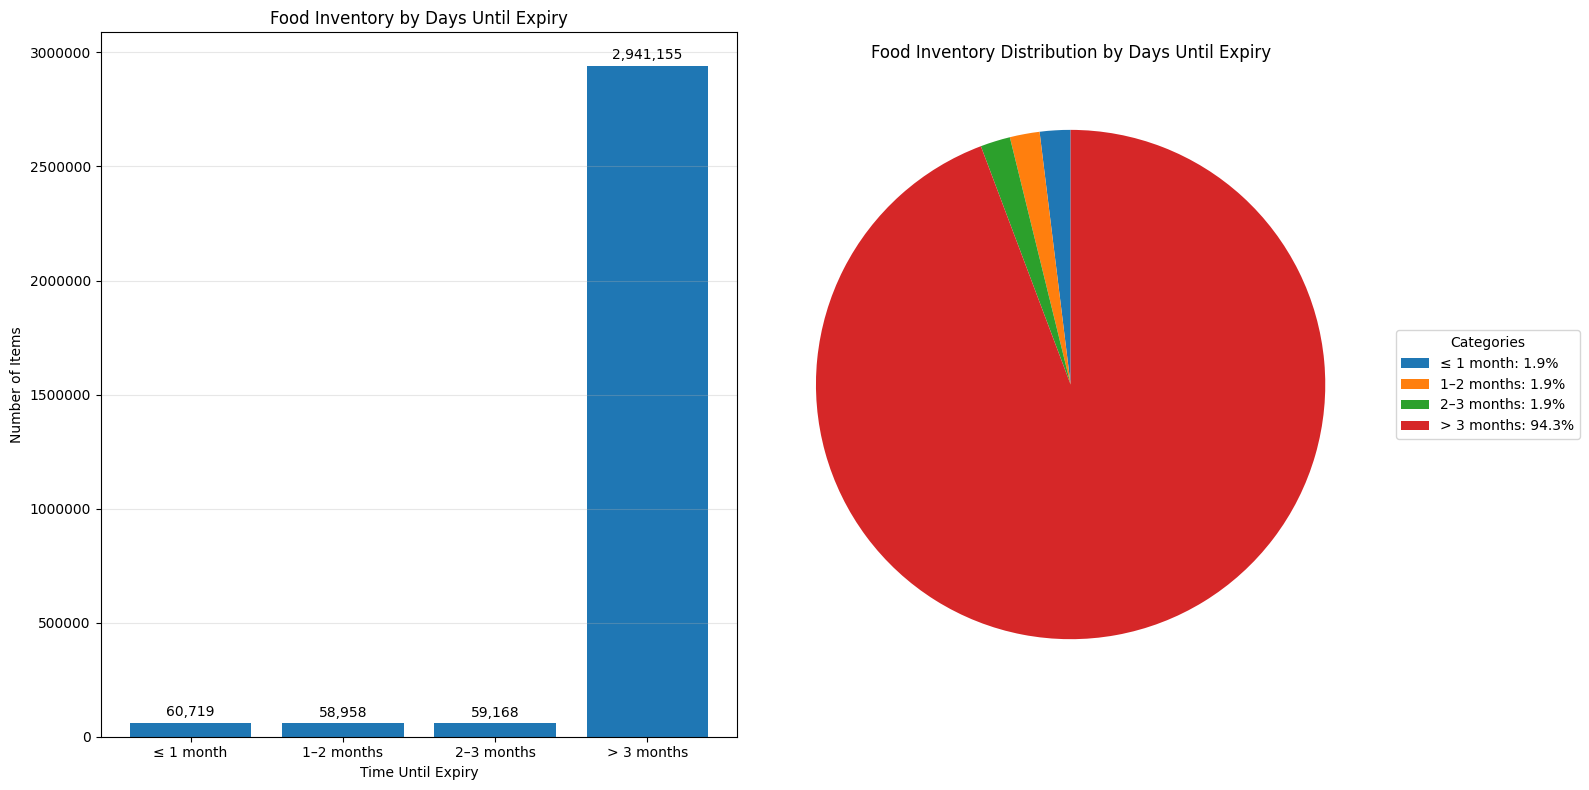

In [6]:
inventory_by_days_to_expiry = get_dataframe_from_query("""
SELECT 
    SUM(CASE WHEN days_until_expiry <= 30 THEN 1 ELSE 0 END) AS [≤ 1 month],
    SUM(CASE WHEN days_until_expiry > 30 AND days_until_expiry <= 60 THEN 1 ELSE 0 END) AS [1–2 months],
    SUM(CASE WHEN days_until_expiry > 60 AND days_until_expiry <= 90 THEN 1 ELSE 0 END) AS [2–3 months],
    SUM(CASE WHEN days_until_expiry > 90 THEN 1 ELSE 0 END) AS [> 3 months]
FROM food_inventory_with_relative_expiry;
""")

categories = inventory_by_days_to_expiry.columns.tolist()
values = inventory_by_days_to_expiry.iloc[0].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

bars = ax1.bar(categories, values)
ax1.set_title('Food Inventory by Days Until Expiry')
ax1.set_xlabel('Time Until Expiry')
ax1.set_ylabel('Number of Items')
ax1.grid(axis='y', alpha=0.3)

ax1.ticklabel_format(style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(values):
    ax1.text(i, v + max(values) * 0.01, f'{int(v):,}', ha='center')

ax1.tick_params(axis='x', rotation=0)

wedges, autotexts = ax2.pie(values, labels=None, autopct=None, startangle=90)
ax2.set_title('Food Inventory Distribution by Days Until Expiry')

total = sum(values)
legend_labels = [f'{cat}: {val/total*100:.1f}%' for cat, val in zip(categories, values)]
ax2.legend(wedges, legend_labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

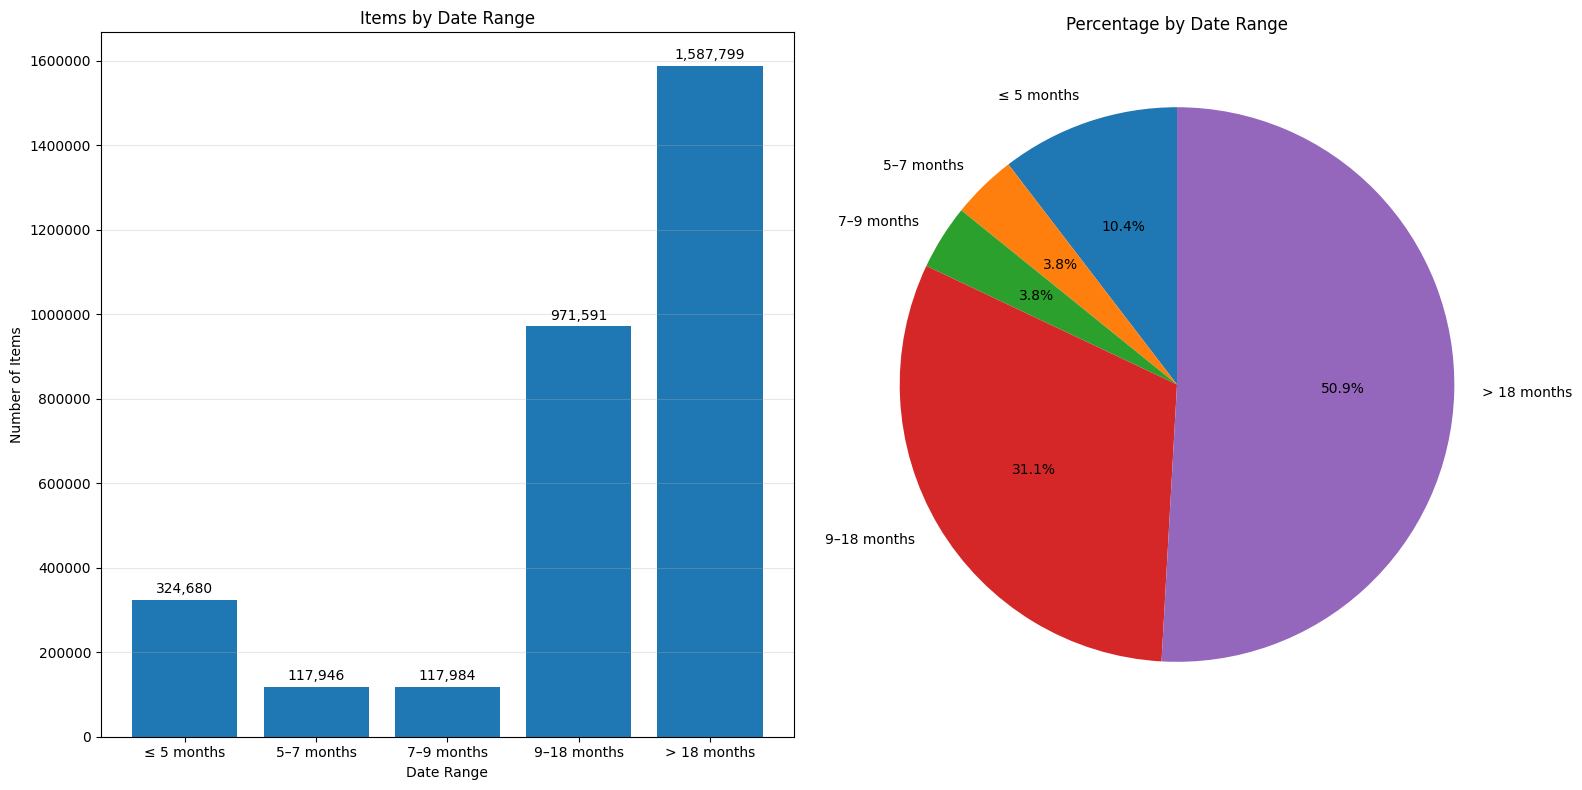

In [8]:
inventory_by_months_to_expiry = get_dataframe_from_query("""
WITH calculated_months AS (
    SELECT ROUND(days_until_expiry / 30, 0)
    AS months_until_expiry
    FROM food_inventory_with_relative_expiry
)
SELECT 
    SUM(CASE WHEN months_until_expiry <= 5 THEN 1 ELSE 0 END) AS [≤ 5 months],
    SUM(CASE WHEN months_until_expiry > 5 AND months_until_expiry <= 7 THEN 1 ELSE 0 END) AS [5–7 months],
    SUM(CASE WHEN months_until_expiry > 7 AND months_until_expiry <= 9 THEN 1 ELSE 0 END) AS [7–9 months],
    SUM(CASE WHEN months_until_expiry > 9 AND months_until_expiry <= 18 THEN 1 ELSE 0 END) AS [9–18 months],
    SUM(CASE WHEN months_until_expiry > 18 THEN 1 ELSE 0 END) AS [> 18 months]
FROM calculated_months;
""")

categories = inventory_by_months_to_expiry.columns.tolist()
values = inventory_by_months_to_expiry.iloc[0].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

bars = ax1.bar(categories, values)
ax1.set_title('Items by Date Range')
ax1.set_xlabel('Date Range')
ax1.set_ylabel('Number of Items')
ax1.grid(axis='y', alpha=0.3)

ax1.ticklabel_format(style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(values):
    ax1.text(i, v + max(values) * 0.01, f'{int(v):,}', ha='center')

ax1.tick_params(axis='x', rotation=0)

wedges, text, autotexts = ax2.pie(values, labels=categories, autopct='%1.1f%%', startangle=90)
ax2.set_title('Percentage by Date Range')

plt.tight_layout()
plt.show()

Now let's create a UI to set the variables and visualize the data with it:

>**Note:** This might take a minute to load...

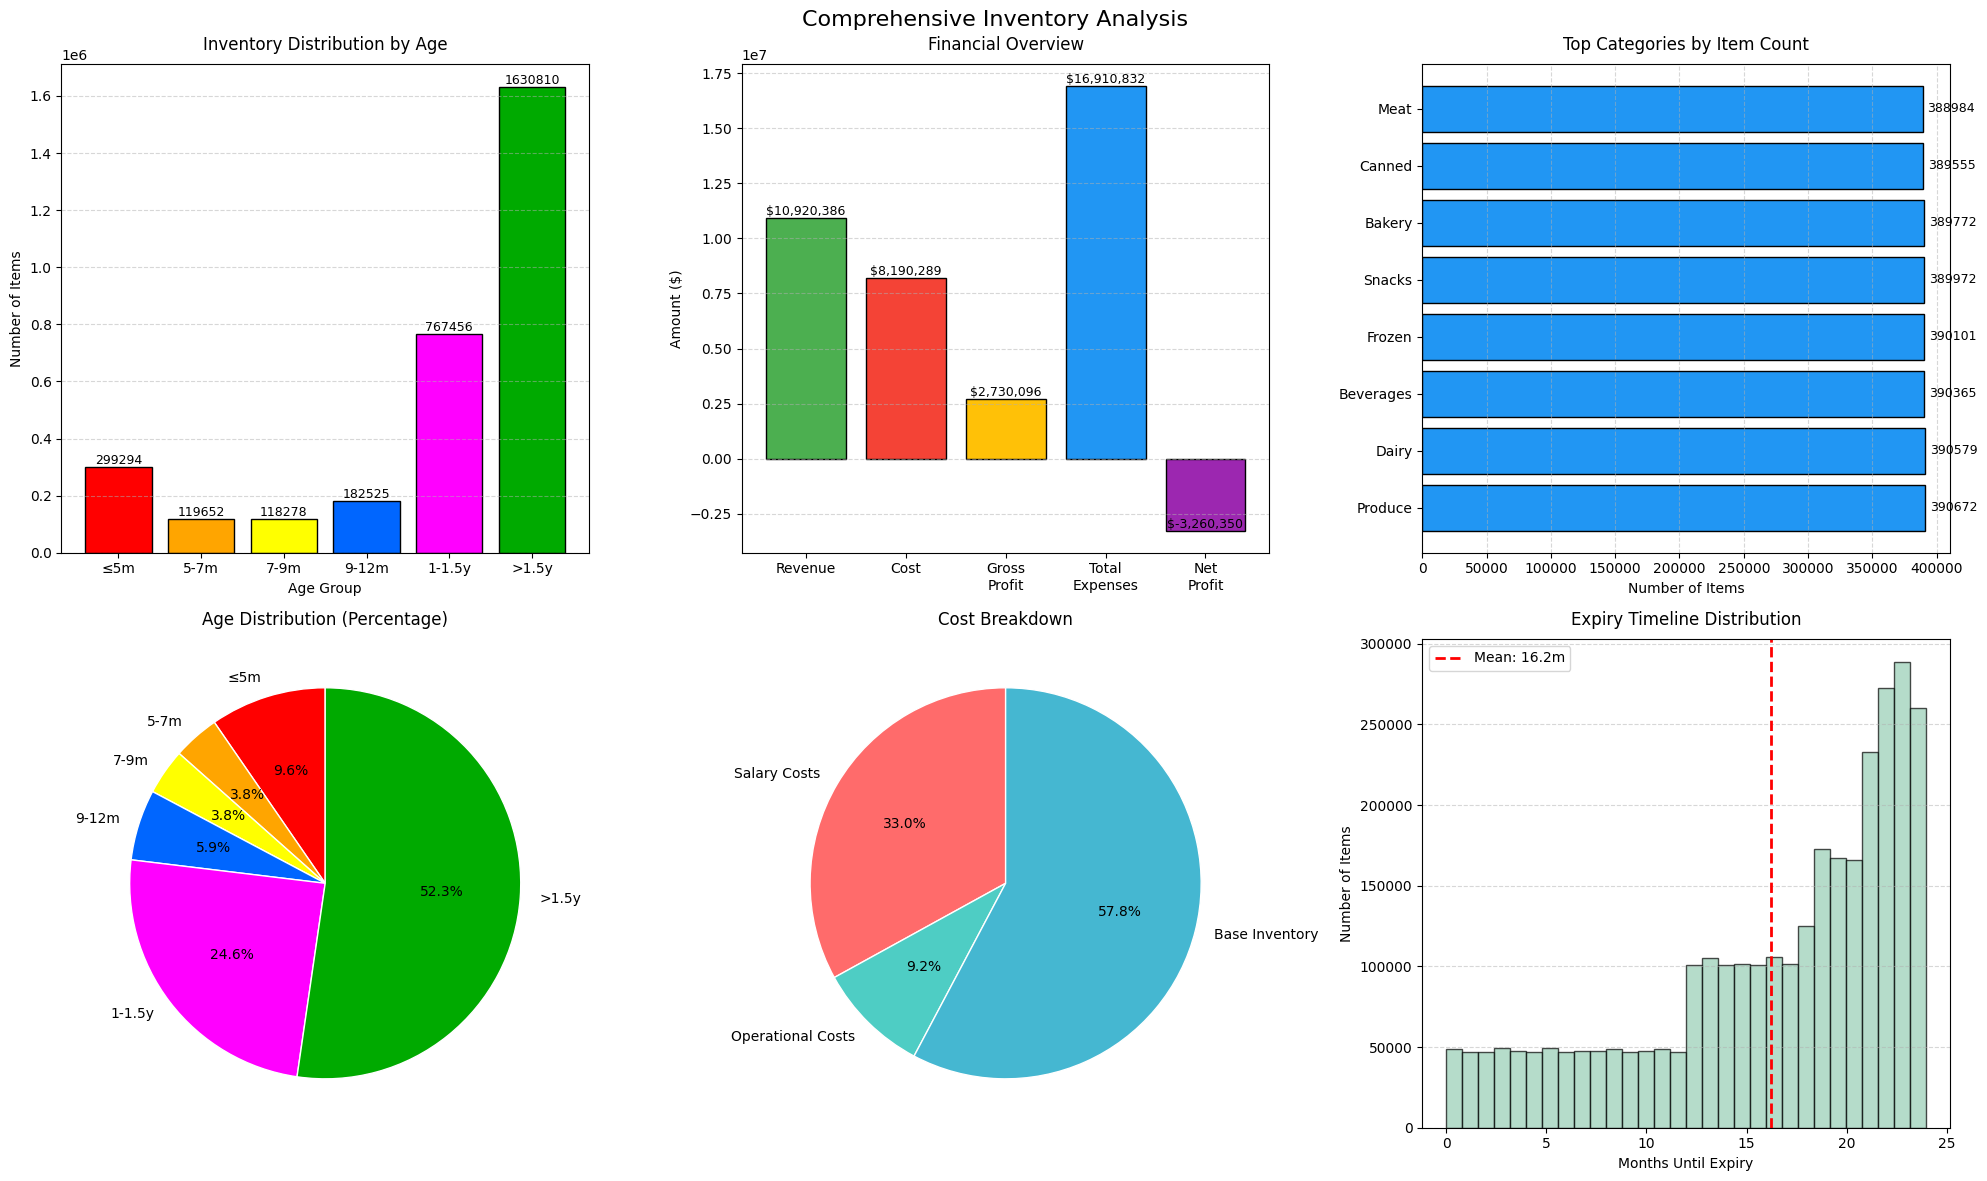

## Comprehensive Analysis Summary

,Metric,Value
0,Total Items,"3,120,000"
1,Total Inventory Value,"$10,920,385.84"
2,Total Salary Costs,"$4,680,000.00"
3,Total Operational Costs,"$1,310,446.30"
4,Total Costs,"$16,910,832.14"
5,Estimated Profits,"$2,730,096.46"
6,Net Value,"$-3,260,349.84"
7,Average months until expiry,16.2
8,Items expiring within 6 months,"360,038"
9,Most common category,Produce


## Age Group Distribution

,Age Group,Count,Percentage
0,≤5m,299294,9.6
1,5-7m,119652,3.8
2,7-9m,118278,3.8
3,9-12m,182525,5.9
4,1-1.5y,767456,24.6
5,>1.5y,1630810,52.3


## Top 10 Categories

,category,count
1,Produce,390672
2,Dairy,390579
3,Beverages,390365
4,Frozen,390101
5,Snacks,389972
6,Bakery,389772
7,Canned,389555
8,Meat,388984


## Sample Financial Data

,Price,Salary cost,Operational cost,Total cost,Profit,Net value
0,3.123620,1.5,0.374834,4.998455,0.780905,-1.093929
1,4.852143,1.5,0.582257,6.934400,1.213036,-0.869221
2,4.195982,1.5,0.503518,6.199500,1.048995,-0.954522
3,3.795975,1.5,0.455517,5.751493,0.948994,-1.006523
4,2.468056,1.5,0.296167,4.264223,0.617014,-1.179153
5,2.467984,1.5,0.296158,4.264142,0.616996,-1.179162
6,2.174251,1.5,0.260910,3.935161,0.543563,-1.217347
7,4.598528,1.5,0.551823,6.650352,1.149632,-0.902191
8,3.803345,1.5,0.456401,5.759746,0.950836,-1.005565
9,4.124218,1.5,0.494906,6.119124,1.031054,-0.963852


In [7]:
def show_graphs(SALARY_COST_PER_ITEM, OPERATIONAL_COST_RATE, PROFIT_MARGIN):
    def handler(b):
        clear_output(wait=True)
        show_variable_editor(has_output=True)
        
        # Get inventory data with simulated prices (since no price column exists)
        inventory_df = get_dataframe_from_query("SELECT * FROM food_inventory;")

        # Generate random prices for demonstration (normally would come from actual price data)
        np.random.seed(42)  # For reproducible results
        inventory_df['Price'] = np.random.uniform(2, 5, size=len(inventory_df))

        # Calculate financial metrics
        inventory_df['Salary cost'] = SALARY_COST_PER_ITEM
        inventory_df['Operational cost'] = inventory_df['Price'] * OPERATIONAL_COST_RATE
        inventory_df['Total cost'] = inventory_df['Price'] + inventory_df['Salary cost'] + inventory_df['Operational cost']
        inventory_df['Profit'] = inventory_df['Price'] * PROFIT_MARGIN
        inventory_df['Net value'] = inventory_df['Price'] + inventory_df['Profit'] - inventory_df['Total cost']

        # Get expiry data for age analysis
        expiry_df = get_dataframe_from_query("SELECT * FROM food_inventory_with_relative_expiry;")
        expiry_df['months_until_expiry'] = expiry_df['days_until_expiry'] / 30.44
        
        # Categorize by age groups
        age_bins = [0, 5, 7, 9, 12, 18, float('inf')]
        age_labels = ['≤5m', '5-7m', '7-9m', '9-12m', '1-1.5y', '>1.5y']
        expiry_df['age_group'] = pd.cut(expiry_df['months_until_expiry'], bins=age_bins, labels=age_labels)
        
        # Age group distribution
        age_distribution = expiry_df['age_group'].value_counts().sort_index()
        
        # Category analysis
        category_counts = get_dataframe_from_query("SELECT category, COUNT(*) as count FROM food_inventory GROUP BY category ORDER BY count DESC;")
        
        # Calculate totals
        total_stats = {
            'Total Items': len(inventory_df),
            'Total Inventory Value': inventory_df['Price'].sum(),
            'Total Salary Costs': inventory_df['Salary cost'].sum(),
            'Total Operational Costs': inventory_df['Operational cost'].sum(),
            'Total Costs': inventory_df['Total cost'].sum(),
            'Estimated Profits': inventory_df['Profit'].sum(),
            'Net Value': inventory_df['Net value'].sum()
        }

        # Create comprehensive visualization with 6 subplots
        fig = plt.figure(figsize=(20, 12))
        fig.suptitle('Comprehensive Inventory Analysis', fontsize=16, y=0.98)

        # Color schemes
        age_colors = ['#FF0000', '#FFA500', '#FFFF00', '#0066FF', '#FF00FF', '#00AA00']
        financial_colors = ['#4CAF50', '#F44336', '#FFC107', '#2196F3', '#9C27B0']
        
        # 1. Age Distribution - Bar Chart
        ax1 = plt.subplot(2, 3, 1)
        bars1 = ax1.bar(age_distribution.index, age_distribution.values, color=age_colors[:len(age_distribution)], edgecolor='black')
        ax1.set_title('Inventory Distribution by Age', fontsize=12, pad=10)
        ax1.set_xlabel('Age Group')
        ax1.set_ylabel('Number of Items')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

        # 2. Financial Overview - Bar Chart
        ax2 = plt.subplot(2, 3, 2)
        financial_categories = ['Revenue', 'Cost', 'Gross\nProfit', 'Total\nExpenses', 'Net\nProfit']
        financial_values = [
            total_stats['Total Inventory Value'],
            total_stats['Total Inventory Value'] - total_stats['Estimated Profits'],
            total_stats['Estimated Profits'],
            total_stats['Total Costs'],
            total_stats['Net Value']
        ]
        bars2 = ax2.bar(financial_categories, financial_values, color=financial_colors, edgecolor='black')
        ax2.set_title('Financial Overview', fontsize=12, pad=10)
        ax2.set_ylabel('Amount ($)')
        ax2.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Add value labels
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'${height:,.0f}', ha='center', va='bottom', fontsize=9)

        # 3. Category Distribution - Horizontal Bar Chart
        ax3 = plt.subplot(2, 3, 3)
        top_categories = category_counts.head(10)  # Top 10 categories
        ax3.barh(top_categories['category'], top_categories['count'], color='#2196F3', edgecolor='black')
        ax3.set_title('Top Categories by Item Count', fontsize=12, pad=10)
        ax3.set_xlabel('Number of Items')
        ax3.grid(axis='x', linestyle='--', alpha=0.5)
        
        # Add value labels
        for i, v in enumerate(top_categories['count']):
            ax3.text(v + max(top_categories['count']) * 0.01, i, f'{v}', va='center', fontsize=9)

        # 4. Age Distribution - Pie Chart
        ax4 = plt.subplot(2, 3, 4)
        wedges, texts, autotexts = ax4.pie(age_distribution.values, labels=age_distribution.index,
                                          autopct='%1.1f%%', startangle=90,
                                          colors=age_colors[:len(age_distribution)],
                                          wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
        ax4.set_title('Age Distribution (Percentage)', fontsize=12, pad=10)

        # 5. Cost Breakdown - Pie Chart
        ax5 = plt.subplot(2, 3, 5)
        cost_categories = ['Salary Costs', 'Operational Costs', 'Base Inventory']
        cost_values = [
            total_stats['Total Salary Costs'],
            total_stats['Total Operational Costs'],
            total_stats['Total Inventory Value'] - total_stats['Estimated Profits']
        ]
        cost_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        wedges, texts, autotexts = ax5.pie(cost_values, labels=cost_categories,
                                          autopct='%1.1f%%', startangle=90,
                                          colors=cost_colors,
                                          wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
        ax5.set_title('Cost Breakdown', fontsize=12, pad=10)

        # 6. Expiry Timeline - Histogram
        ax6 = plt.subplot(2, 3, 6)
        expiry_months = expiry_df['months_until_expiry'].dropna()
        ax6.hist(expiry_months, bins=30, color='#96CEB4', edgecolor='black', alpha=0.7)
        ax6.set_title('Expiry Timeline Distribution', fontsize=12, pad=10)
        ax6.set_xlabel('Months Until Expiry')
        ax6.set_ylabel('Number of Items')
        ax6.grid(axis='y', linestyle='--', alpha=0.5)
        ax6.axvline(x=expiry_months.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {expiry_months.mean():.1f}m')
        ax6.legend()

        plt.tight_layout()
        plt.show()

        # Print comprehensive summary
        summary_data = []
        for stat, value in total_stats.items():
            if isinstance(value, (int, float)):
                if 'Value' in stat or 'Cost' in stat or 'Profit' in stat:
                    formatted_value = f"${value:,.2f}"
                else:
                    formatted_value = f"{value:,}"
                summary_data.append({'Metric': stat, 'Value': formatted_value})

        # Add additional metrics
        summary_data.extend([
            {'Metric': 'Average months until expiry', 'Value': f"{expiry_months.mean():.1f}"},
            {'Metric': 'Items expiring within 6 months', 'Value': f"{len(expiry_df[expiry_df['months_until_expiry'] <= 6]):,}"},
            {'Metric': 'Most common category', 'Value': category_counts.iloc[0]['category']},
            {'Metric': 'Number of categories', 'Value': f"{len(category_counts):,}"}
        ])

        summary_df = pd.DataFrame(summary_data)

        display(Markdown("## Comprehensive Analysis Summary"))
        display(summary_df)

        # Display age group breakdown
        display(Markdown("## Age Group Distribution"))
        age_summary = pd.DataFrame({
            'Age Group': age_distribution.index,
            'Count': age_distribution.values,
            'Percentage': (age_distribution.values / age_distribution.sum() * 100).round(1)
        })
        display(age_summary)

        # Display top categories
        display(Markdown("## Top 10 Categories"))
        category_summary = category_counts.head(10).reset_index(drop=True)
        category_summary.index = category_summary.index + 1
        display(category_summary)

        # Display sample financial data
        display(Markdown("## Sample Financial Data"))
        display(inventory_df[['Price', 'Salary cost', 'Operational cost', 'Total cost', 'Profit', 'Net value']].head(10))
        
    return handler

def go_button_handler(b):
    return show_graphs(
        widgets_dict['salary_cost_per_item'].value,
        widgets_dict['operational_cost_rate'].value / 100,
        widgets_dict['profit_margin'].value / 100
    )(b)

# Configuration constants
CONFIG = {
    'salary_cost_per_item': {
        'value': 1.50,
        'label': 'Salary cost per item ($):'
    },
    'operational_cost_rate': {
        'value': 15,
        'label': 'Operational cost rate (%):'
    },
    'profit_margin': {
        'value': 20,
        'label': 'Profit margin (%):'
    }
}

# Widget creation
widgets_dict = {
    name: widgets.FloatText(value=config['value'])
    for name, config in CONFIG.items()
}

def reset_values():
    for name, widget in widgets_dict.items():
        widget.value = CONFIG[name]['value']

def check_values(change=None):
    has_changes = any(
        widget.value != CONFIG[name]['value'] 
        for name, widget in widgets_dict.items()
    )
    reset_button.disabled = not has_changes

# Setup reset button and observers
reset_button = create_button('Reset values', 'danger', lambda b: reset_values())
reset_button.disabled = True

for widget in widgets_dict.values():
    widget.observe(check_values, names='value')

def show_variable_editor(has_output=False):
    # Create labels and widgets pairs
    navigation = []
    
    for name, config in CONFIG.items():
        navigation.extend([
            widgets.Label(value=config['label']),
            widgets_dict[name]
        ])
    
    # Add action buttons
    navigation.extend([
        create_button('Go', 'primary', handler=go_button_handler),
        reset_button
    ])
    
    if has_output:
        navigation.append(create_button('Clear output', 'danger', handler=lambda b: show_variable_editor()))
    
    navigation.append(exit_button())
    display_with_navigation(navigation)
    if has_output: display(Markdown(">**Note:** This might take a minute to load..."))

show_variable_editor()

Finally, we close the connection to the database:

In [ ]:
conn.close()